In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score
from sklearn.base import clone

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from data_utils import construct_df, ohe_chars_stage, characters, stages
from modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses

import xgboost as xgb

In [3]:
p2019_5s_ohe=pd.read_pickle('saved_data/p2019_5s_ohe.pkl')

In [4]:
p2019_games = p2019_5s_ohe.groupby(['id']).first()

In [5]:
p2019_games

,p1_char,p2_char,stage,frames_elapsed,p1_stocks,p2_stocks,p1_damage,p2_damage,winner,p1_FOX,p1_FALCO,p1_MARTH,p1_SHEIK,p1_JIGGLYPUFF,p1_PEACH,p1_ICE_CLIMBERS,p1_CAPTAIN_FALCON,p1_PIKACHU,p1_SAMUS,p1_DR_MARIO,p1_YOSHI,p1_LUIGI,p1_GANONDORF,p1_MARIO,p1_YOUNG_LINK,p1_DONKEY_KONG,p1_LINK,p1_GAME_AND_WATCH,p1_ROY,p1_MEWTWO,p1_ZELDA,p1_NESS,p1_PICHU,p1_BOWSER,p1_KIRBY,p2_FOX,p2_FALCO,p2_MARTH,p2_SHEIK,p2_JIGGLYPUFF,p2_PEACH,p2_ICE_CLIMBERS,p2_CAPTAIN_FALCON,p2_PIKACHU,p2_SAMUS,p2_DR_MARIO,p2_YOSHI,p2_LUIGI,p2_GANONDORF,p2_MARIO,p2_YOUNG_LINK,p2_DONKEY_KONG,p2_LINK,p2_GAME_AND_WATCH,p2_ROY,p2_MEWTWO,p2_ZELDA,p2_NESS,p2_PICHU,p2_BOWSER,p2_KIRBY,stage_BATTLEFIELD,stage_FINAL_DESTINATION,stage_DREAM_LAND_N64,stage_YOSHIS_STORY,stage_FOUNTAIN_OF_DREAMS,stage_POKEMON_STADIUM
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Game_20190411T003344,FOX,FOX,YOSHIS_STORY,0,4.0,4.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Game_20190411T010416,FOX,FALCO,YOSHIS_STORY,0,4.0,4.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Game_20190418T160900,MARTH,MARTH,FINAL_DESTINATION,0,4.0,4.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Game_20190418T161212,MARTH,MARTH,DREAM_LAND_N64,0,4.0,4.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Game_20190418T161501,MARTH,MARTH,YOSHIS_STORY,0,4.0,4.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Game_20190421T215007,FALCO,FALCO,BATTLEFIELD,0,4.0,4.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Game_20190421T215343,FALCO,FALCO,POKEMON_STADIUM,0,4.0,4.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Game_20190421T215708,MARTH,FALCO,FINAL_DESTINATION,0,4.0,4.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
p2019_games['stage'].value_counts()

BATTLEFIELD           2106
YOSHIS_STORY          1527
DREAM_LAND_N64        1370
FINAL_DESTINATION     1311
POKEMON_STADIUM       1218
FOUNTAIN_OF_DREAMS    1140
Name: stage, dtype: int64

In [47]:
def num_games_with_char(df, character):
    char_in_game = np.array(df['p1_'+character].astype(int) | df['p2_'+character].astype(int))
    total = np.sum(char_in_game)
    #print(character + ': {:} appearances in {:} games'.format(total,len(df)))
    return total

def make_matchup_matrix(df, character_list):
    cl = (len(character_list))
    win_matrix = np.zeros((cl,cl))
    games_matrix = np.zeros((cl,cl))
          
    p1_list = df['p1_char']
    p2_list = df['p2_char']
    win_list = df['winner']
    
    for p1,p2,win in zip(p1_list,p2_list, win_list):
        p1_i = characters.index(p1)
        p2_i = characters.index(p2)
        win_matrix[p1_i,p2_i] += win
        win_matrix[p2_i,p1_i] += 1-win
        games_matrix[p1_i, p2_i] += 1
        games_matrix[p2_i, p1_i] += 1
    
    return win_matrix/games_matrix, win_matrix, games_matrix
          

<ipython-input-47-c34f222f7295>:24: RuntimeWarning: invalid value encountered in true_divide
  return win_matrix/games_matrix, win_matrix, games_matrix


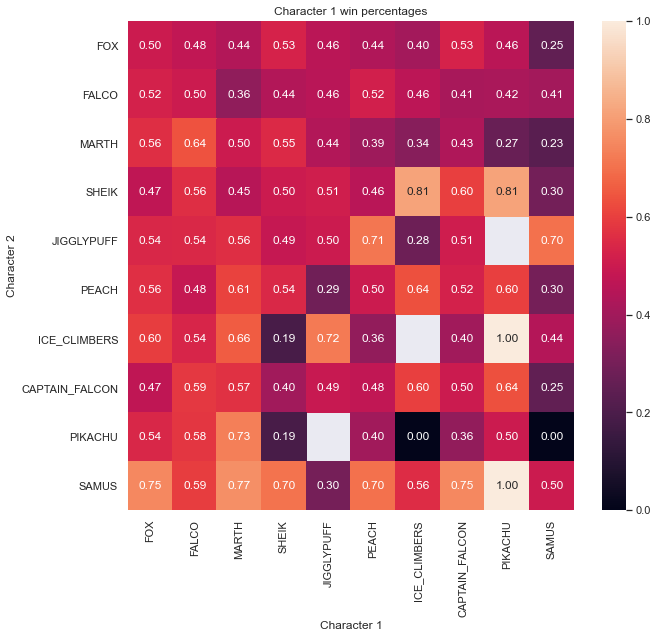

In [59]:
plt.figure(figsize = (10,9))
sns.heatmap(data=make_matchup_matrix(p2019_games,characters)[0][:10,:10],
            annot=True, xticklabels = characters[:10],yticklabels = characters[:10], fmt='.2f')
plt.xlabel('Character 1')
plt.ylabel('Character 2')
plt.title('Character 1 win percentages')
plt.show()

In [27]:
num_games_with_char(p2019_games,'FALCO')

3481

In [17]:
p2019_games['p2_char'].

FOX               2272
FALCO             1719
MARTH             1666
CAPTAIN_FALCON     674
SHEIK              657
PEACH              410
JIGGLYPUFF         302
SAMUS              175
YOSHI              135
GANONDORF          123
ICE_CLIMBERS       114
PIKACHU             74
LUIGI               71
GAME_AND_WATCH      49
DR_MARIO            42
NESS                32
ZELDA               32
YOUNG_LINK          30
LINK                28
PICHU               19
MARIO               14
DONKEY_KONG         13
ROY                  7
MEWTWO               6
BOWSER               4
KIRBY                4
Name: p2_char, dtype: int64

In [28]:
a=['a','b']

In [30]:
a.index('a')

0